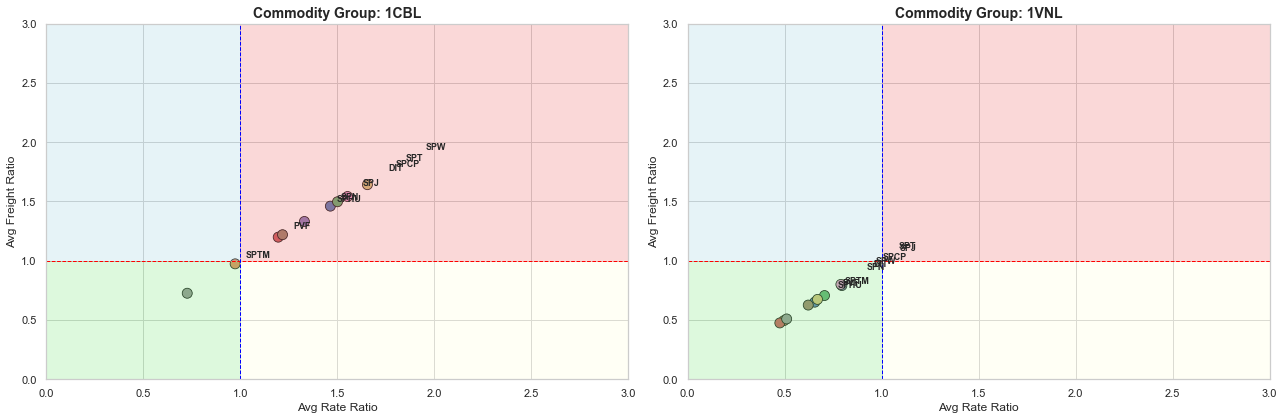

In [6]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import ast

# Load and prepare the data
df = pd.read_csv("../../data/downloads/freight_comparison_20250422_134106.csv")
df_clean = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["freight_ratio", "rate_ratio"])
df_clean["commodity_group"] = df_clean["unique_commodity_group_input"].apply(
    lambda x: ast.literal_eval(x)[0] if pd.notnull(x) else "Unknown"
)
df_clean = df_clean[df_clean['outlier_flag']=='Normal']

grouped = df_clean.groupby(["site", "commodity_group"]).agg(
    avg_freight_ratio=("freight_ratio", "mean"),
    avg_rate_ratio=("rate_ratio", "mean")
).reset_index()

# Fixed quadrant ranges
x_min, x_max = 0,3
y_min, y_max = 0, 3
x_split = 1
y_split = 1

commodity_groups = grouped["commodity_group"].unique()
fig, axes = plt.subplots(nrows=1, ncols=len(commodity_groups), figsize=(9 * len(commodity_groups), 6))
axes = axes if isinstance(axes, np.ndarray) else [axes]
sns.set(style="whitegrid", context="notebook")

for i, group in enumerate(commodity_groups):
    subset = grouped[grouped["commodity_group"] == group]
    ax = axes[i]

    # ✅ Equal-area quadrants
    ax.add_patch(Rectangle((x_min, y_split), x_split - x_min, y_max - y_split, color="lightblue", alpha=0.3))     # Top-left
    ax.add_patch(Rectangle((x_split, y_split), x_max - x_split, y_max - y_split, color="lightcoral", alpha=0.3))  # Top-right
    ax.add_patch(Rectangle((x_min, y_min), x_split - x_min, y_split - y_min, color="lightgreen", alpha=0.3))      # Bottom-left ✅
    ax.add_patch(Rectangle((x_split, y_min), x_max - x_split, y_split - y_min, color="lightyellow", alpha=0.3))   # Bottom-right

    # Lines
    ax.axhline(y_split, color='red', linestyle='--', lw=1)
    ax.axvline(x_split, color='blue', linestyle='--', lw=1)

    # Scatter
    sns.scatterplot(
        data=subset,
        x="avg_rate_ratio",
        y="avg_freight_ratio",
        hue="site",
        ax=ax,
        s=100,
        edgecolor="black",
        legend=False
    )

    for _, row in subset.iterrows():
        ax.text(row["avg_rate_ratio"] + 0.3, row["avg_freight_ratio"] + 0.3, row["site"],
                fontsize=9, weight='bold')

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title(f"Commodity Group: {group}", fontsize=14, weight='bold')
    ax.set_xlabel("Avg Rate Ratio")
    ax.set_ylabel("Avg Freight Ratio")

plt.tight_layout()
plt.show()
